In [2]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt

url = '10.168.20.20:5010'

In [230]:
pipeline = [
    {'$match': {'name': {'$in': ['app2', 'app5']}, 'roles._id': '5afdb8cf93beb10025c13f4f'}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {'name': 1, 'deps': 1, 'deps': 1, 'nodes.name': 1, 'nodes.steps': 1, 'nodes.deps': 1}}
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'deps': [{'endpoint': 'rest', 'name': 'app1', '_id': '5b293cff5ec68b1828d5fa7d', 'family': 'Application'}], 'name': 'app2', 'nodes': [{'deps': [{'endpoint': 'rest', 'name': 'Db - mysql', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database'}], 'name': 'app4', 'steps': 1}, {'name': 'Db - mysql', 'steps': 1}, {'name': 'broker', 'steps': 1}, {'deps': [{'endpoint': 'rest', 'name': 'broker', '_id': '5b29836b3dee72509767a790', 'family': 'Broker'}, {'endpoint': 'rest', 'name': 'Db - mysql', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database'}, {'endpoint': 'rest', 'name': 'app4', '_id': '5b3d1b0ed7f17a0025e48d33', 'family': 'Application'}], 'name': 'app1', 'steps': 0}], '_id': '5b293d045ec68b1828d5fa7e'}, {'deps': [{'endpoint': 'rest', 'name': 'Db - mysql', '_id': '5b3d1a70d7f17a0025e48d32', 'family': 'Database'}], 'name': 'app5', 'nodes': [{'name': 'Db - mysql', 'steps': 0}], '_id': '5b3d1b4fd7f17a0025e48d34'}]}


In [262]:
class InfraNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()

    def create_edge(self, parent, item):
        if 'deps' in parent:
            for dps in parent['deps']:
                w = item.get('steps', -1)
                self.graph.add_edge(item['name'], dps['name'], weight=w+1)

    def create_node(self, item):
        self.graph.add_node(item['name'], object=item)

    def make(self, data):
        for item in data:
            self.create_node(item)
            self.create_edge(item, item)

            for sub in item['nodes']:
                self.create_node(sub)
                self.create_edge(sub, sub)

        return self

    def get_graph(self):
        return self.graph

    
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
        return pos

network = InfraNetwork()
network.make(data.get('items')).get_graph()

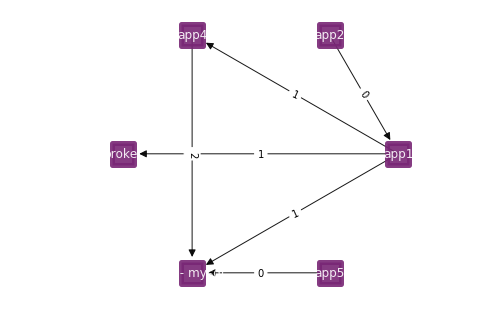

{'app1': array([1.00000000e+00, 2.45045699e-08]), 'app2': array([0.49999998, 0.86602546]), 'app4': array([-0.50000004,  0.8660254 ]), 'broker': array([-9.99999970e-01, -6.29182054e-08]), 'Db - mysql': array([-0.49999989, -0.86602541]), 'app5': array([ 0.49999992, -0.86602541])}


In [263]:
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

print(draw.get_cardials())

In [271]:
list(network.graph.neighbors('app1'))

['broker', 'Db - mysql', 'app4']